In [270]:
import requests
import time

import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import shap
import seaborn as sns

In [2]:
pd.options.display.float_format = '{:_.2f}'.format

In [3]:
API_KEY = '84f6d11d1973b0c18be917aa'

In [4]:
rates = requests.get(f'https://v6.exchangerate-api.com/v6/{API_KEY}/latest/RUB').json()['conversion_rates']
rate = rates.pop('RUB')
rates.update({'RUR': rate})

In [5]:
def in_(sub_strs, str_):
  for sub_str in sub_strs:
    if sub_str.lower() in str_.lower():
      return True
  return False

In [6]:
jobs = []
for i in range(20):
  items = requests.get('https://api.hh.ru/vacancies', params={'page': i, 'per_page': 100, 'text': 'Data Scientist'}).json()['items']
  jobs.extend(items)
  if len(items) < 100:
    break
jobs = [job for job in jobs if in_(['data',
                                    'ml',
                                    'machine learning',
                                    'nlp',
                                    'cv',
                                    'computer vision',
                                    'дата',
                                    'данных',
                                    'компьютерное зрение',
                                    'LLM', 'recsys'], job['name'])]

In [324]:
print('Количество вакансий:', len(jobs))

Количество вакансий: 467


In [27]:
salaries = []

for i, job in enumerate(jobs):
  resp = requests.get(f'https://api.hh.ru/vacancies/{job["id"]}').json()
  time.sleep(1)
  
  job['key_skills'] = resp['key_skills']
  salary = job['salary']
  if salary is not None:
    if salary['from'] is None:
      salary_amount = (salary['to'] * 0.66 + salary['to']) / 2
    elif salary['to'] is None:
      salary_amount = (salary['from'] + salary['from'] * 1.5) / 2
    else:
      salary_amount = (salary['from'] + salary['to']) / 2

    if salary['currency'] in rates:
      salary_amount /= rates[salary['currency']]
      salaries.append(salary_amount)
    else:
      salaries.append(None)

  else:
    salaries.append(None)

salaries = pd.Series(salaries)

<Axes: >

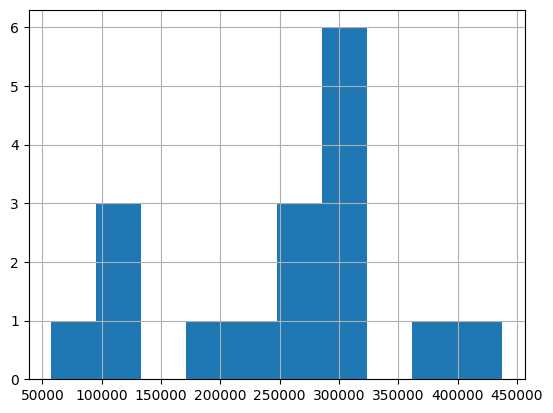

In [29]:
salaries.hist()

In [32]:
salaries.describe().rename('Сатистика по зарплатам')

count        17.00
mean    245_186.64
std     101_407.61
min      57_412.47
25%     175_000.00
50%     275_000.00
75%     290_500.00
max     437_500.00
Name: Сатистика по зарплатам, dtype: float64

In [33]:
jobs_df = pd.DataFrame(jobs)
jobs_df.key_skills = jobs_df.key_skills.apply(lambda skills: [skill['name'] for skill in skills])
jobs_df.employer = jobs_df.employer.apply(lambda el: el['name'])
jobs_df.schedule = jobs_df.schedule.apply(lambda el: el['name'])
jobs_df.area = jobs_df.area.apply(lambda el: el['name'])
jobs_df.professional_roles = jobs_df.professional_roles.apply(lambda el: el[0]['name'])
jobs_df.working_time_intervals = jobs_df.working_time_intervals.apply(lambda el: el[0]['name'] if len(el) > 0 else None)
jobs_df.employment = jobs_df.employment.apply(lambda el: el['name'])
jobs_df.department = jobs_df.department.apply(lambda el: el['name'] if el is not None else None)
jobs_df.experience = jobs_df.experience.apply(lambda el: el['name'])
jobs_df.drop(['type',
              'adv_response_url',
              'is_adv_vacancy',
              'adv_context',
              'show_logo_in_search',
              'branding',
              'accept_incomplete_resumes',
              'working_days',
              'working_time_modes',
              'response_url',
              'sort_point_distance',
              'contacts',
              'relations',
              'alternate_url',
              'url',
              'insider_interview',
              'apply_alternate_url',
              'archived'], axis=1, inplace=True)
jobs_df.set_index('id', inplace=True)

In [36]:
def flatten_series(nested_series):
    flat_list = []
    for element in nested_series:
        if isinstance(element, list):
            flat_list.extend(flatten_series(element))
        else:
            flat_list.append(element)
    return pd.Series(flat_list)

In [39]:
print('Самые важные навыки')
flatten_series(jobs_df.key_skills.tolist()).value_counts().rename('количество упоменаний навыка').head(20)

Самые важные навыки


Python                       221
SQL                          126
Machine Learning              65
ML                            54
PyTorch                       44
Big Data                      44
Data Science                  41
NLP                           34
Математическая статистика     34
Pandas                        33
Анализ данных                 33
Data Analysis                 32
Spark                         31
Git                           25
Машинное обучение             23
Hadoop                        21
Computer Vision               21
LLM                           19
ETL                           15
Numpy                         15
Name: количество упоменаний навыка, dtype: int64

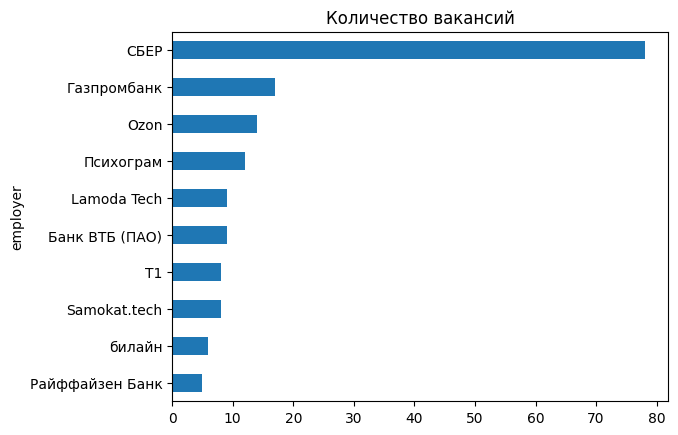

In [49]:
jobs_df.employer.value_counts().head(10).sort_values().plot.barh(title='Количество вакансий')
plt.show()

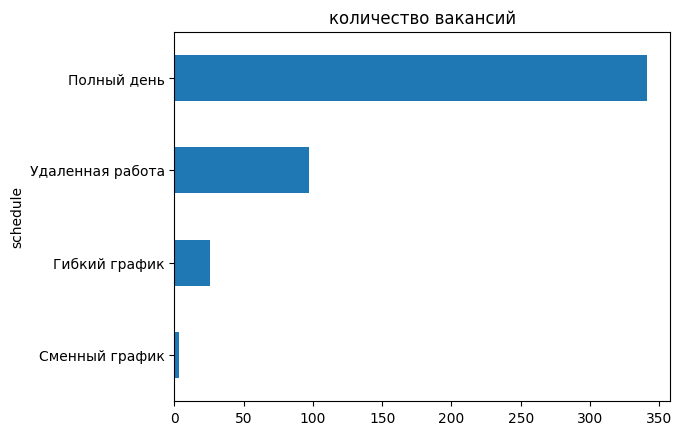

In [48]:
jobs_df.schedule.value_counts().sort_values().plot.barh(title='количество вакансий')
plt.show()

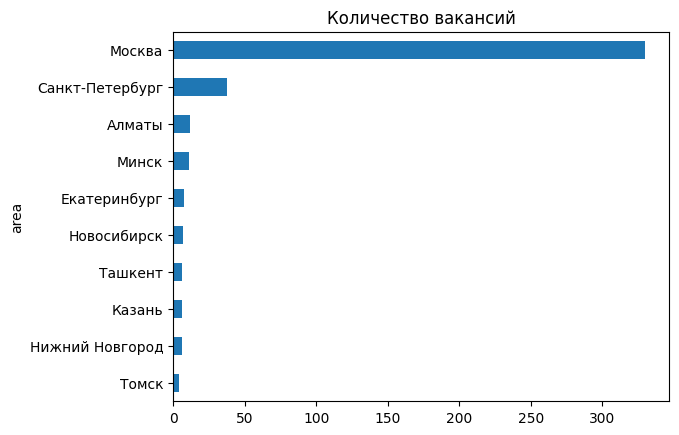

In [51]:
jobs_df.area.value_counts().head(10).sort_values().plot.barh(title='Количество вакансий')
plt.show()

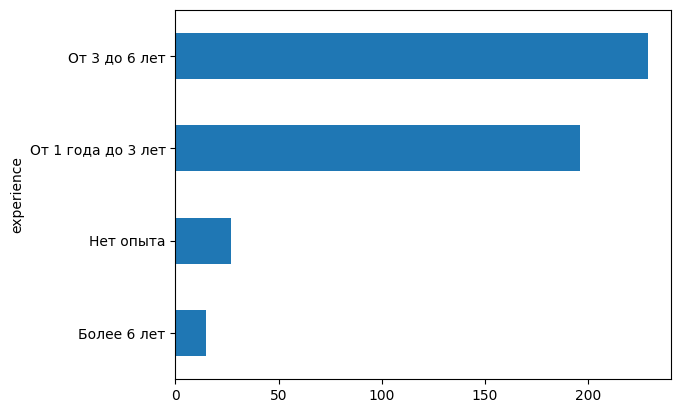

In [54]:
jobs_df.experience.value_counts().sort_values().plot.barh('количество вакансий')
plt.show()

In [57]:
print('Количество вакансий с указанной зарплатой', (~jobs_df.salary.isna()).sum())
print('Доля вакансий с указанной зарплатой', format((~jobs_df.salary.isna()).mean(), '.2f'))

Количество вакансий с указанной зарплатой 54
Доля вакансий с указанной зарплатой 0.12


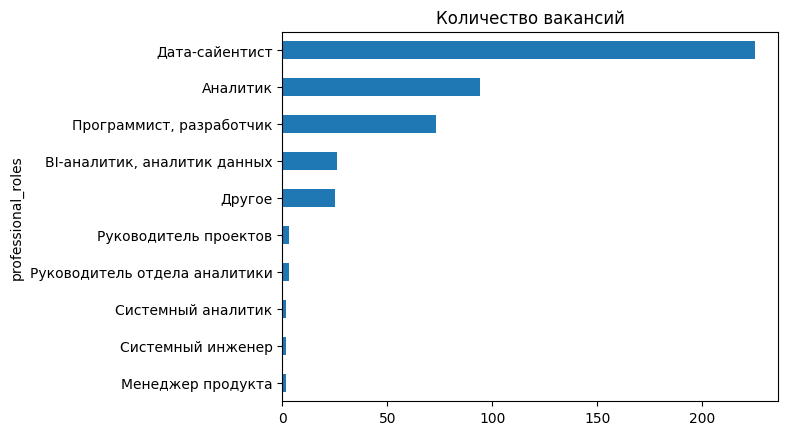

In [60]:
jobs_df.professional_roles.value_counts().head(10).sort_values().plot.barh(title='Количество вакансий')
plt.show()

In [61]:
jobs_df['salary_aprox'] = jobs_df['salary']\
.apply(lambda el: None if el is None else
       el['to'] / rates[el['currency']] if el['from'] is None
       else el['from'] / rates[el['currency']] if el['to'] is None
       else (el['from'] + el['to']) / 2 / rates[el['currency']])

In [62]:
jobs_df['salary_aprox'].describe()

count        54.00
mean    188_355.22
std     141_934.72
min      25_000.00
25%      55_603.12
50%     182_500.00
75%     268_750.00
max     646_352.72
Name: salary_aprox, dtype: float64

In [89]:
flatten_series(jobs_df.name.str.lower().str.split())\
.apply(lambda el: ''.join(char for char in el if char.isalnum()))\
.value_counts().head(20)

data            436
scientist       380
senior           83
в                54
middle           48
                 47
engineer         44
nlp              39
команду          34
данных           27
junior           23
и                23
аналитик         21
middlesenior     21
ml               14
lead             14
llm              14
analyst          13
по               10
learning         10
Name: count, dtype: int64

In [78]:
jobs_df['grade'] = jobs_df['name']\
.apply(lambda el: 'lead' if 'lead' in el.lower()
else 'middle_plus' if ('middle' in el.lower() and 'senior' in el.lower()) or 'middle+' in el.lower()
else 'senior' if 'senior' in el.lower()
else 'middle' if 'middle' in el.lower()
else 'junior' if 'junior' in el.lower()
else 'intern' if 'intern' in el.lower() or 'стажёр' in el.lower() or 'стажер' in el.lower()
else None)

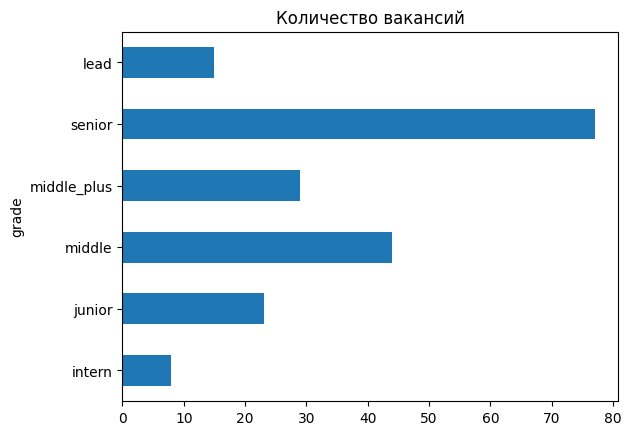

In [87]:
jobs_df.grade.value_counts()\
.loc[['intern',
      'junior',
      'middle',
      'middle_plus',
      'senior',
      'lead']].plot.barh(title='Количество вакансий')
plt.show()

In [134]:
jobs_df_f = jobs_df[~jobs_df['salary_aprox'].isna()]

In [135]:
X = jobs_df_f.drop(['salary', 'address', 'published_at', 'created_at', 'snippet', 'key_skills', 'salary_aprox'], axis=1)
y = jobs_df_f['salary_aprox']

In [221]:
model = cb.CatBoostRegressor(cat_features=X.columns.tolist(), silent=True, iterations=20, depth=8)

In [222]:
y_pred = cross_val_predict(model, X.fillna('-'), y, cv=4)

In [223]:
print('mae', mae(y, y_pred))
print('mape', mape(y, y_pred))

mae 74574.09694229421
mape 0.5810110830366844


In [226]:
model = cb.CatBoostRegressor(cat_features=X.columns.tolist(), silent=True, iterations=20, depth=8)
model.fit(X.fillna('-'), y)

In [233]:
pd.DataFrame({'feature': model.feature_names_, 'importance': model.feature_importances_})\
.sort_values(by='importance', ascending=False)

,feature,importance
12,employment,24.29
7,schedule,23.15
10,professional_roles,16.21
13,grade,12.71
11,experience,12.11
2,department,6.26
9,accept_temporary,5.03
8,working_time_intervals,0.24
0,premium,0.00
1,name,0.00


In [234]:
X.drop(['premium', 'name', 'has_test', 'response_letter_required', 'area', 'employer'], axis=1, inplace=True)

In [245]:
model = cb.CatBoostRegressor(cat_features=pd.get_dummies(X).columns.tolist(), silent=True)
y_pred = cross_val_predict(model, pd.get_dummies(X), y, cv=4)
print('mae', mae(y, y_pred))
print('mape', mape(y, y_pred))

mae 76683.05845618239
mape 0.5103576148539627


In [248]:
model = cb.CatBoostRegressor(cat_features=pd.get_dummies(X).columns.tolist(), silent=True)
model.fit(pd.get_dummies(X), y)
imps = pd.DataFrame({'feature': model.feature_names_, 'importance': model.feature_importances_})\
.sort_values(by='importance', ascending=False)
imps.importance /= imps.importance.sum()
imps

,feature,importance
21,grade_junior,0.13
16,experience_От 3 до 6 лет,0.11
14,experience_Нет опыта,0.10
5,schedule_Полный день,0.09
10,professional_roles_Дата-сайентист,0.07
15,experience_От 1 года до 3 лет,0.06
8,"professional_roles_BI-аналитик, аналитик данных",0.06
23,grade_middle,0.05
18,employment_Проектная работа,0.04
7,working_time_intervals_Можно работать сменами ...,0.03


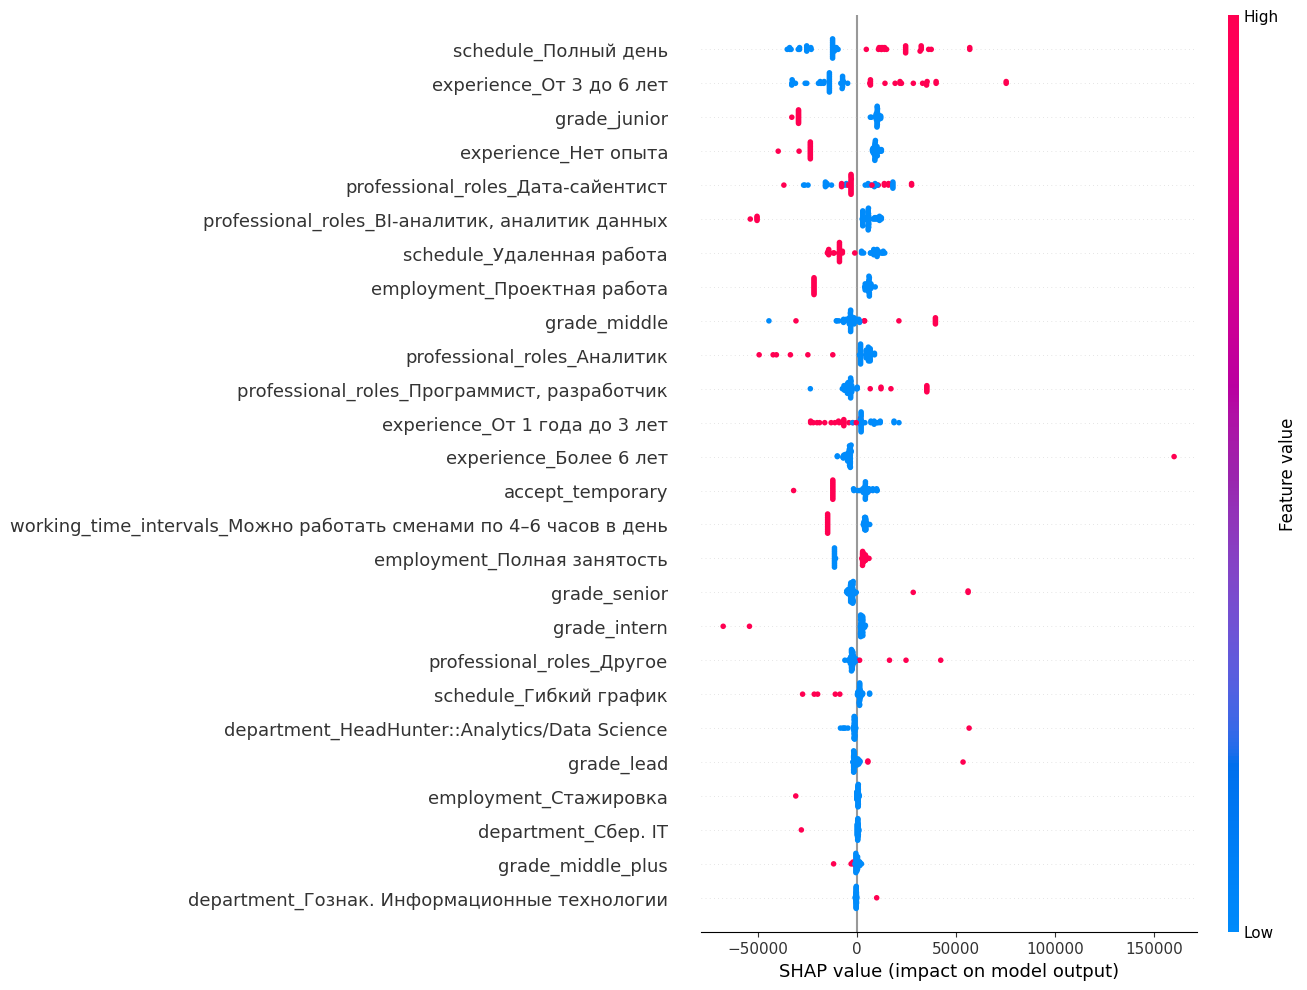

In [264]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(pd.get_dummies(X))
shap.plots.beeswarm(shap_values=shap_values, max_display=30)
plt.show()

In [289]:
jobs_dummies = pd.get_dummies(jobs_df[X.columns])
jobs_dummies_f = pd.get_dummies(X)

compare = pd.merge(jobs_dummies.mean().rename('all'), jobs_dummies_f.mean().rename('salary_specified'),
         how='inner',
         left_index=True,
         right_index=True)

In [290]:
compare['diff'] = (compare['all'] - compare['salary_specified']).abs()

In [292]:
compare.sort_values(by='diff', ascending=False)

,all,salary_specified,diff
schedule_Полный день,0.73,0.43,0.30
schedule_Удаленная работа,0.21,0.48,0.27
accept_temporary,0.04,0.26,0.22
employment_Полная занятость,0.96,0.76,0.20
experience_Нет опыта,0.06,0.26,0.20
employment_Проектная работа,0.03,0.22,0.20
working_time_intervals_Можно работать сменами по 4–6 часов в день,0.03,0.22,0.19
grade_junior,0.05,0.24,0.19
experience_От 3 до 6 лет,0.49,0.35,0.14
grade_senior,0.16,0.06,0.11


In [297]:
jobs_df['predict_salary'] = model.predict(jobs_dummies[jobs_dummies_f.columns])

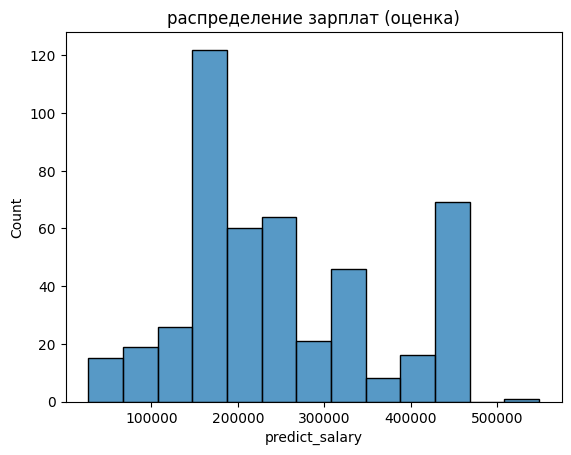

In [321]:
sns.histplot(jobs_df['predict_salary'])\
.set(title='распределение зарплат (оценка)')
plt.show()

In [302]:
jobs_df['predict_salary'].describe()

count       467.00
mean    251_337.96
std     116_453.94
min      27_040.57
25%     167_125.53
50%     221_375.75
75%     327_940.47
max     548_279.17
Name: predict_salary, dtype: float64

In [318]:
print('моя зарплата в Альфа банке')
model.predict(pd.DataFrame({'accept_temporary': [False],
                        'department_HeadHunter::Analytics/Data Science': [False],
                        'department_Гознак. Информационные технологии': [False],
                        'department_Сбер. IT': [False],
                        'schedule_Гибкий график': [False],
                        'schedule_Полный день': [True],
                        'schedule_Удаленная работа': [True],
                        'working_time_intervals_Можно работать сменами по\xa04–6 часов в\xa0день': [False],
                        'professional_roles_BI-аналитик, аналитик данных': [False],
                        'professional_roles_Аналитик': [False],
                        'professional_roles_Дата-сайентист': [True],
                        'professional_roles_Другое': [False],
                        'professional_roles_Программист, разработчик': [False],
                        'experience_Более 6 лет': [False],
                        'experience_Нет опыта': [True],
                        'experience_От 1 года до 3 лет': [False],
                        'experience_От 3 до 6 лет': [False],
                        'employment_Полная занятость': [False],
                        'employment_Проектная работа': [False],
                        'employment_Стажировка': [True],
                        'grade_intern': [True],
                        'grade_junior': [False],
                        'grade_lead': [False],
                        'grade_middle': [False],
                        'grade_middle_plus': [False],
                        'grade_senior': [False]}))[0]

моя зарплата в Альфа банке


43416.433853030525